<a href="https://colab.research.google.com/github/kperes/Colab_Weather_Prediction/blob/main/Weather_prediction_Ensemble_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS**

Os modelos de ML usados ​​são:

1.K-Nearest Neighbour (KNN)\
2.Support Vector Machine (SVM)\
3.Gradient Boost Classifier (GBC)\
4.Extreme Gradient Boosting (XGBC)

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
import missingno as mso
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

***Importando o DataSet***\
Importar o DataSet do Google Drive.

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data=pd.read_csv("/content/gdrive/MyDrive/DataSet/seattle-weather.csv")

**ANALISANDO O CONJUNTO DE DADOS**

Existem 6 variáveis ​​neste conjunto de dados:

4 Variáveis ​​contínuas.\
1 Variável para acomodar a data.\
1 Variável referente ao clima.

In [4]:
data.shape

(1461, 6)

Com isso temos 6 colunas com um total de 1461 linhas como nossas observações no conjunto de dados.

In [5]:
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


**EXPLORAÇÃO DE DADOS**

É o processo de Explorar os dados do conjunto de dados "RAW" que pegamos ou importamos.

Primeiro vamos lidar com as variáveis ​​categóricas

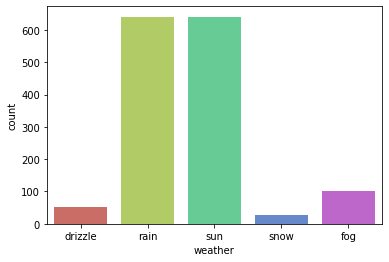

In [6]:
import warnings
warnings.filterwarnings('ignore')
sns.countplot("weather",data=data,palette="hls")

A partir do gráfico acima, podemos ver que o dataset contém maior quantidade de dados detalhados climáticos de chuva e sol, mas que também possui alguns adicionais, como garoa, neve e neblina.

In [7]:
countrain=len(data[data.weather=="rain"])
countsun=len(data[data.weather=="sun"])
countdrizzle=len(data[data.weather=="drizzle"])
countsnow=len(data[data.weather=="snow"])
countfog=len(data[data.weather=="fog"])


In [8]:
print("Rain:{:2f}%".format((countrain/(len(data.weather))*100)))
print("Sun:{:2f}%".format((countsun/(len(data.weather))*100)))
print("Fog:{:2f}%".format((countfog/(len(data.weather))*100)))
print("Drizzle:{:2f}%".format((countdrizzle/(len(data.weather))*100)))
print("Snow:{:2f}%".format((countsnow/(len(data.weather))*100)))

Rain:43.874059%
Sun:43.805613%
Fog:6.913073%
Drizzle:3.627652%
Snow:1.779603%


**VARIÁVEIS NUMÉRICAS OU CONTÍNUAS**

A seguir vamos explorar as variáveis ​​contínuas

In [9]:
data[["precipitation","temp_max","temp_min","wind"]].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


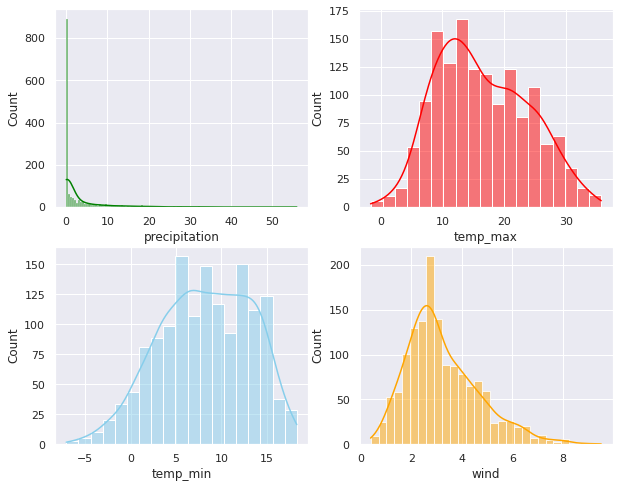

In [10]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=data,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.histplot(data=data,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.histplot(data=data,x="temp_min",kde=True,ax=axs[1,0],color='skyblue')
sns.histplot(data=data,x="wind",kde=True,ax=axs[1,1],color='orange')

De acordo com as imagens acima fica claro que a precipitação e o vento são positivamente enviesados.

E temp_min é negativamente inclinado e ambos têm alguns outliers.

**ENCONTRAR OS OUTILERS NO DATA SET**\

Podemos encontrar os outliers no conjunto de dados usando os seguintes gráficos:

1.   Hist plot
2.   Box plot
3.   Violin plot
4.   Dist plot



**VIOLIN PLOT**

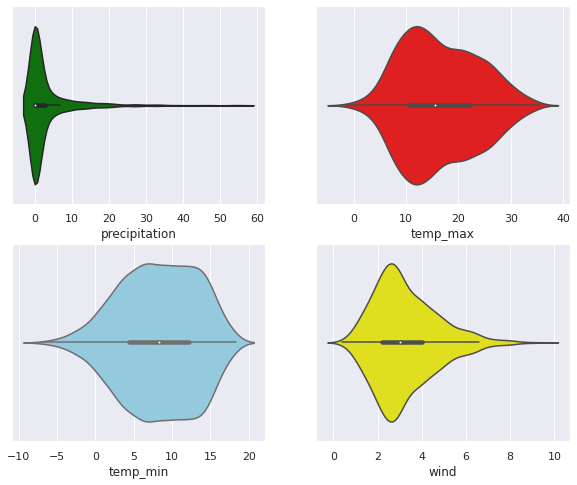

In [11]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.violinplot(data=data,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.violinplot(data=data,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.violinplot(data=data,x="temp_min",kde=True,ax=axs[1,0],color='skyblue')
sns.violinplot(data=data,x="wind",kde=True,ax=axs[1,1],color='yellow')

A partir do violin plot acima, podemos entender claramente a assimetria dos dados, pois o TAIL indica a assimetria.

**INCLINAÇÃO USANDO BOXPLOT**

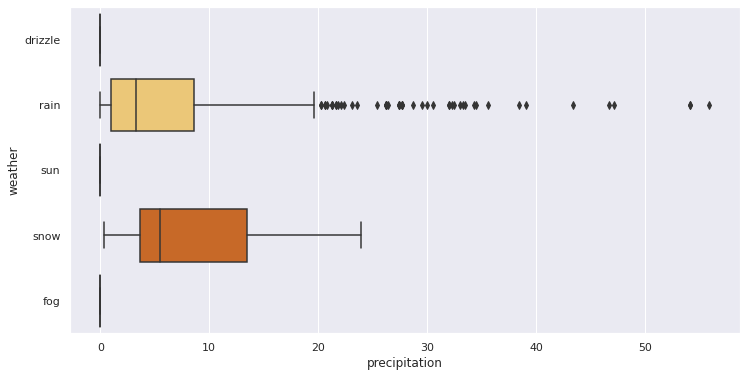

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot("precipitation","weather",data=data,palette="YlOrBr")

A partir do Box plot acima entre o Tempo e a Precipitação, o valor chuva tem muitos valores discrepantes positivos e tanto chuva quanto neve foram positivamente enviesados.

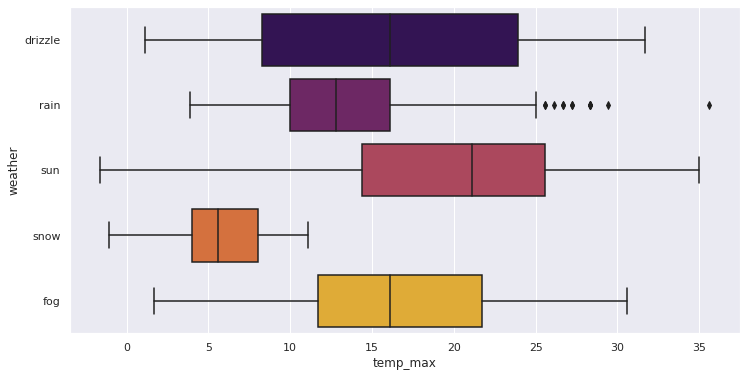

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot("temp_max","weather",data=data,palette="inferno")

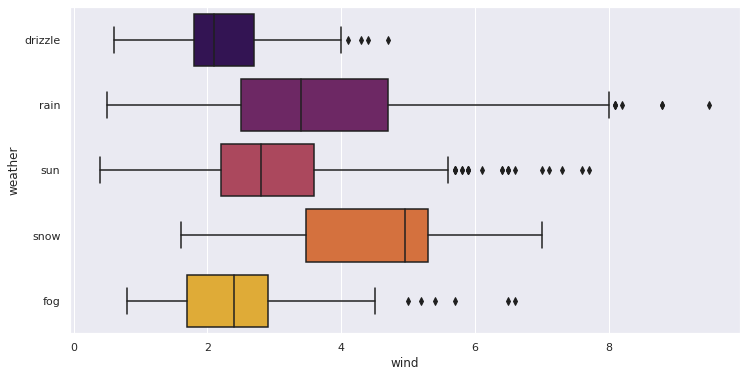

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot("wind","weather",data=data,palette="inferno")

A partir dos box plot acima, descobrimos que cada atributo do clima tem alguns outliers positivos e são os dois tipos de assimetria.

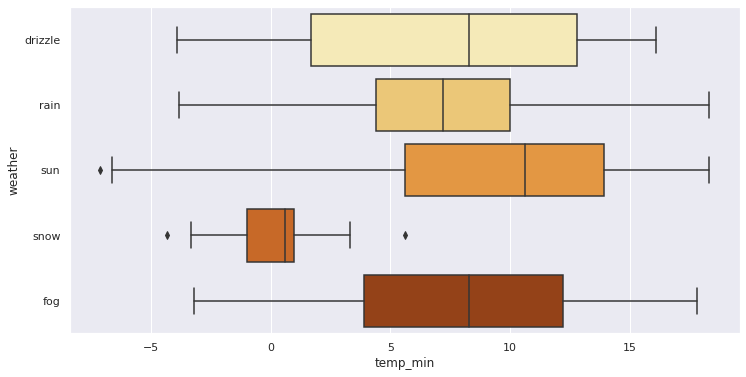

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot("temp_min","weather",data=data,palette="YlOrBr")

**MAPA DE CALOR**

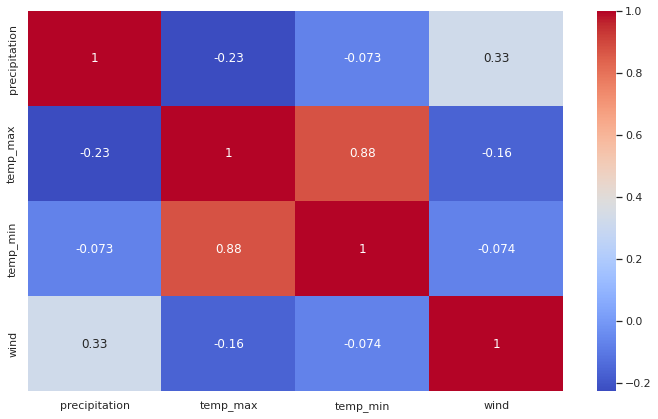

In [16]:
plt.figure(figsize=(12,7))
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')

Há uma correlação positiva entre temp_max e temp_min.

Pearson correlation: -0.22855481643297046
T Test and P value: Ttest_indResult(statistic=-51.60685279531918, pvalue=0.0)


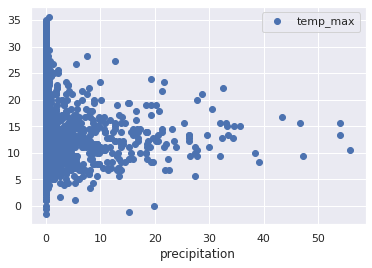

In [17]:
data.plot("precipitation","temp_max",style='o') 
print("Pearson correlation:",data["precipitation"].corr(data["temp_max"]))
print("T Test and P value:",stats.ttest_ind(data["precipitation"],data["temp_max"]))

Pearson correlation: -0.16485663487495486
T Test and P value: Ttest_indResult(statistic=-67.3601643301846, pvalue=0.0)


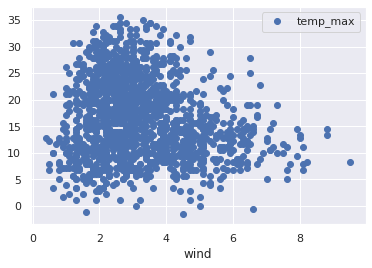

In [18]:
data.plot("wind","temp_max",style='o') 
print("Pearson correlation:",data["wind"].corr(data["temp_max"]))
print("T Test and P value:",stats.ttest_ind(data["wind"],data["temp_max"]))

A partir do resultado acima do teste T e o valor P de 0 indica que a hipótese nula nas colunas correspondentes é rejeitada e as colunas são estatisticamente significativas.

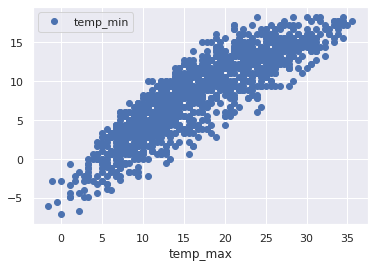

In [19]:
data.plot("temp_max","temp_min",style='o') 

**VALORES NULOS**

In [20]:
data.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

Verificando valores nulos no conjunto de dados

O gráfico abaixo mostra que todas as colunas no conjunto de dados não contêm valores nulos, pois cada coluna contém um total de 1.461 observações.

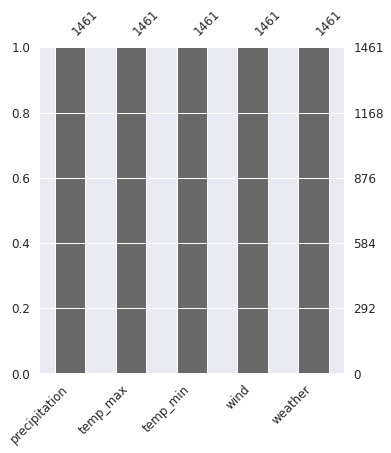

In [21]:
plt.figure(figsize=(12,6))
axz=plt.subplot(1,2,2)
mso.bar(data.drop(["date"],axis=1),ax=axz,fontsize=12);

**PRÉ-PROCESSAMENTO DE DADOS**\

Elimine Variáveis ​​Desnecessárias

Neste conjunto de dados, a data é uma variável desnecessária, pois não afeta os dados, portanto, pode ser descartada.

In [22]:
df=data.drop(["date"],axis=1)

Remover valores atípicos e infinitos

Como este conjunto de dados contém valores atípicos, ele será removido para tornar o conjunto de dados mais uniforme.

In [23]:
Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
df=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]

Tratamento de distribuição enviesada

In [24]:
df.precipitation=np.sqrt(df.precipitation)
df.wind=np.sqrt(df.wind)

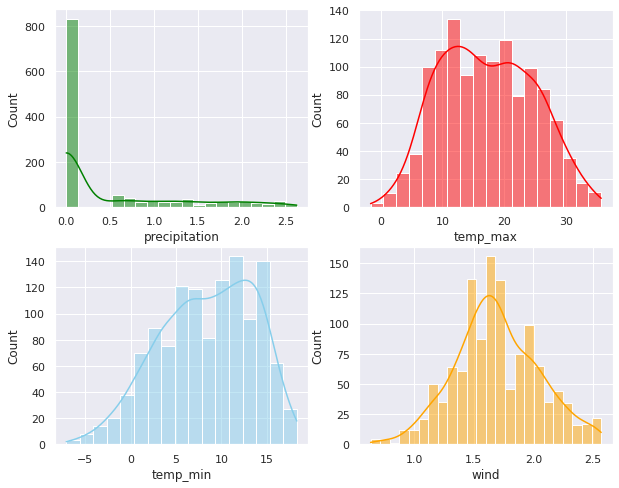

In [25]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=df,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.histplot(data=df,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.histplot(data=df,x="temp_min",kde=True,ax=axs[1,0],color='skyblue')
sns.histplot(data=df,x="wind",kde=True,ax=axs[1,1],color='orange')

In [26]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.000000,12.8,5.0,2.167948,drizzle
2,0.894427,11.7,7.2,1.516575,rain
4,1.140175,8.9,2.8,2.469818,rain
5,1.581139,4.4,2.2,1.483240,rain
6,0.000000,7.2,2.8,1.516575,rain


Escalando as variáveis ​​meteorológicas usando o rótulo Encoder:

In [27]:
lc=LabelEncoder()
df["weather"]=lc.fit_transform(df["weather"])

DIVIDINDO O CONJUNTO DE DADOS EM VARIÁVEIS DEPENDENTES E INDEPENDENTES:

In [28]:
x=((df.loc[:,df.columns!="weather"]).astype(int)).values[:,0:]
y=df["weather"].values

In [29]:
df.weather.unique()

array([0, 2, 4, 3, 1])

**TREINAMENTO DE ALGORITMOS E MODELO**

In [30]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.1, random_state=2)

**K-NEAREST NEIGHBOR CLASSIFIER:**

In [31]:
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)

KNeighborsClassifier()

**SUPPORT VECTOR MACHINE**

In [32]:
svm=SVC()
svm.fit(x_train,y_train)

SVC()

**GRADIENT BOOSTING CLASSIFIER**

In [33]:
gbc=GradientBoostingClassifier(subsample=0.5, n_estimators=450, max_depth=5, max_leaf_nodes=25)
gbc.fit(x_train,y_train)

GradientBoostingClassifier(max_depth=5, max_leaf_nodes=25, n_estimators=450,
                           subsample=0.5)

**EXTREME GRADIENT BOOSTING**

In [34]:
# Instanciar o modelo XGBoost.
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', max_depth=6, learning_rate=0.1, n_estimators=200, random_state=2, n_jobs=-1, subsample = 1) 
# Chamar o fit para o modelo.
xgb.fit(x_train,y_train)

XGBClassifier(max_depth=6, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', random_state=2)

In [35]:
print("KNN Accuracy:{:.2f}%".format(knn.score(x_test,y_test)*100))
print("SVM Accuracy:{:.2f}%".format(svm.score(x_test,y_test)*100))
print("GBC Accuracy:{:.2f}%".format(gbc.score(x_test,y_test)*100))
print("XGB Accuracy:{:.2f}%".format(xgb.score(x_test,y_test)*100))

KNN Accuracy:75.00%
SVM Accuracy:77.42%
GBC Accuracy:83.06%
XGB Accuracy:83.87%


**VERIFICANDO A ENTRADA DO USUÁRIO**

"precipitation","temp_max","temp_min","wind"

In [36]:
input=[[1.140175,8.9,2.8,2.469818]]
ot=xgb.predict(input)
print("The weather is:")
if(ot==0):
    print("Drizzle")
elif(ot==1):
    print("Fog")
elif(ot==2):
    print("Rain")
elif(ot==3):
    print("snow")
else:
    print("Sun")

The weather is:
Rain


https://github.com/vega/vega/blob/main/docs/data/seattle-weather.csv